In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import yfinance as yf
from statsmodels.sandbox.tools import tools_pca
from sklearn.decomposition import PCA

In [2]:
def compareModelGraph(model1, model2):
    plt.figure(figsize=(15, 10))
    plt.rcParams["font.size"] = "20"
    plt.plot(range(len(model1.yTest)), model1.yTest, label="real")
    plt.plot(range(len(model1.yPred)), model1.yPred, label="model1")
    plt.plot(range(len(model2.yPred)), model2.yPred, label="model2")
    plt.ylabel("y", fontsize=15)
    plt.xlabel("x", fontsize=15)
    plt.legend(loc="lower right", fontsize=15)
    plt.show()
    return

In [3]:
def graphTrainTestLoss(model, title=None):
    plt.plot(range(1,len(model.modelHistory.history["loss"])+1), model.modelHistory.history["loss"], label="Train loss")
    plt.plot(range(1,len(model.modelHistory.history["val_loss"])+1), model.modelHistory.history["val_loss"], label="Test loss")
    plt.ylabel("MSE")
    plt.xlabel("epoch")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [5]:
class MLP:
    def __init__(self, xyTrainTest, batchNorm=None, dropout=None, dropoutProb=0.2, layerN=3, actFunc="relu", nn=64, alpha=0, lr=0.01):
        actFuncDict = {"relu": tf.keras.layers.ReLU(negative_slope=alpha), "tanh": tf.keras.layers.Activation('tanh')}
        assert isinstance(xyTrainTest, (list, tuple)) and (len(xyTrainTest) == 4)
        assert isinstance(actFunc, str) and actFunc.lower() in actFuncDict.keys()
        assert (batchNorm is None) or isinstance(batchNorm, (int, list))
        assert (dropout is None) or isinstance(dropout, (int, list))
        assert layerN > 0
        self.xTrain, self.yTrain, self.xTest, self.yTest = xyTrainTest
        self.trainLen = len(self.xTrain)
        self.layerN = layerN
        self.batchNorm = batchNorm
        self.dropout = dropout
        self.dropoutProb = dropoutProb
        self.actFunc = actFuncDict.get(actFunc.lower())
        self.nn = nn
        self.lr = lr
        self.unNorm = False
        self.donePred = False
        return
    
    def buildModel(self):
        layerN = self.layerN
        batchNorm = self.batchNorm
        dropout = self.dropout
        model = tf.keras.models.Sequential()
        for i in range(1,(layerN+1)):
            model.add(tf.keras.layers.Dense(self.nn, activation=self.actFunc))
            if batchNorm and ((i == batchNorm) or (isinstance(batchNorm, list) and i in batchNorm)):
                model.add(tf.keras.layers.BatchNormalization())
            if dropout and ((i == dropout) or (isinstance(dropout, list) and i in dropout)):
                model.add(tf.keras.layers.Dropout(self.dropoutProb))
        model.add(tf.keras.layers.Dense(1, activation=self.actFunc))
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        model.compile(optimizer=optimizer, loss="mse")
        
        return model

    def train(self, bs=32, ntry=25, epochs=100):
        validLen = math.ceil(self.trainLen * 0.2)
        model = self.buildModel()
        self.modelHistory = model.fit(self.xTrain, self.yTrain, batch_size=bs, epochs=epochs, shuffle=True, validation_data=(self.xTest, self.yTest), verbose=0)
        self.bestModel = model
        bestLoss = model.evaluate(self.xTrain[-validLen:], self.yTrain[-validLen:])
        
        for i in range(ntry):
            model = self.buildModel()
            history = model.fit(self.xTrain, self.yTrain, batch_size=bs, epochs=epochs, shuffle=True, validation_data=[self.xTest, self.yTest], verbose=0)
            if model.evaluate(self.xTrain, self.yTrain) < bestLoss:
                self.bestModel = model
                self.modelHistory = history
                bestLoss = model.evaluate(self.xTrain[-validLen:], self.yTrain[-validLen:])
        return bestLoss

    def predict(self):
        self.yPred = self.bestModel.predict(self.xTest)
        return
    
    def RMSE(self, l=None, h=None):
        if (not self.unNorm) and (l is not None) and (h is not None):
            self.yTest = self.yTest * (h-l) + l
            self.yPred = self.yPred * (h-l) + l
            self.unNorm = True
        self.rmse = np.sqrt(np.mean(np.square(self.yTest-self.yPred)))
        return self.rmse
    
    def genGraph(self, l=None, h=None, title=None):
        testLen = len(self.yTest)
        if not self.donePred:
            self.predict()
            self.donePred = True
        yTest = self.yTest
        yPred = self.yPred
        if (not self.unNorm) and (l is not None) and (h is not None):
            yTest = yTest * (h-l) + l
            yPred = yPred * (h-l) + l
            self.yTest = yTest
            self.yPred = yPred
            self.unNorm = True
        plt.figure(figsize=(15, 10))
        plt.rcParams["font.size"] = "20"
        plt.plot(range(testLen), yTest, label="true")
        plt.plot(range(testLen), yPred, label="predict")
        if title is not None:
            plt.title(title)
        plt.ylabel("y", fontsize=15)
        plt.xlabel("x", fontsize=15)
        plt.legend(loc="lower right", fontsize=15)
        plt.show()
        return

In [6]:
class DataProcessor:
    def __init__(self):
        return
    
    def generate_train_test(self, df, seqLen, covid=True, split=0.8, trainLen=None, norm=False, pca=None):
        if not covid:
            df = df.loc[df.index < "2020-03-01"] 
        if trainLen is None:
            trainLen = math.ceil(len(df) * split)
        train = df.iloc[:trainLen]
        test = df.iloc[trainLen:]
        if pca is not None:
            pcaDfTrain = train.loc[:,pca].values
            pcaDfTest = test.loc[:,pca].values
            train.drop(pca, axis=1, inplace=True)
            test.drop(pca, axis=1, inplace=True)
            pcaObj = PCA(0.95)
            pcaObj.fit(pcaDfTrain)
            train = train.join(pd.DataFrame(pcaObj.transform(pcaDfTrain), index=train.index))
            test = test.join(pd.DataFrame(pcaObj.transform(pcaDfTest), index=test.index))
        print(train)
        if norm:
            l = train.min()
            h = train.max()
            self.l = l.iloc[0]
            self.h = h.iloc[0]
            train = (train - l)/(h-l)
            test = (test - l)/(h-l)
        targetTrain = train.iloc[:,0]
        targetTest = test.iloc[:,0]
        facTrain = train.iloc[:,1:]
        facTest = test.iloc[:,1:]
        
        xTrainL, yTrainL, xTestL, yTestL = [], [], [], []
        for i in range(len(train) - seqLen):
            xTrainL.append(np.hstack([targetTrain.iloc[i:(i+seqLen)].values.flatten("F"), facTrain.iloc[i:(i+seqLen)].values.flatten("F")]))
            yTrainL.append(targetTrain.iloc[(i+seqLen)].flatten())
        for i in range(len(test) - seqLen):
            xTestL.append(np.hstack([targetTest.iloc[i:(i+seqLen)].values.flatten("F"), facTest.iloc[i:(i+seqLen)].values.flatten("F")]))
            yTestL.append(targetTest.iloc[(i+seqLen)].flatten())
        self.trainLen = trainLen
        self.testStartDate = df.index[trainLen]
        return [np.array(xTrainL), np.array(yTrainL), np.array(xTestL), np.array(yTestL)]

In [7]:
tf.random.set_seed(4012)

In [8]:
start = "2012-03-01"
end = "2022-03-01"
oilPrice = yf.download("CL=F", start=start, end=end).loc[:,["Close"]]

[*********************100%***********************]  1 of 1 completed


In [9]:
opecPrice = pd.read_csv("./dataset/OPEC-ORB.csv", index_col=0, parse_dates=True)

In [10]:
facDict = {"Close": ["DX-Y.NYB"], "Volume": ["CL=F"]}
# facDict = {"Close": ["DX-Y.NYB"]}
factors = list(set([i for arr in facDict.values() for i in arr]))
mulIdx = pd.MultiIndex.from_tuples([(key, val) for key in facDict.keys() for val in facDict.get(key)])
if len(factors) == 1:
    mulIdx = list(facDict.keys())
facDf = yf.download(factors, start=start, end=end).loc[:, mulIdx]
if facDf.columns.nlevels > 1:
    facDf.columns = [" ".join(pair[::-1]) for pair in facDf.columns]

[*********************100%***********************]  2 of 2 completed


In [11]:
tmpRatesDf = pd.read_csv("./dataset/rates.csv", index_col=0, parse_dates=True)
ratesDf = pd.DataFrame(index=oilPrice.index).join(tmpRatesDf).ffill()
ratesPeriod = [1/12, 1/4, 1/2, 1, 2, 3, 5, 7, 10]
contRatesDf = ratesDf.copy()
for i in range(len(ratesDf.columns)):
    if ratesPeriod[i] < 1:
        contRatesDf.iloc[:,i] = np.log(ratesDf.iloc[:,i]*ratesPeriod[i] + 1)/ratesPeriod[i]
    else:
        contRatesDf.iloc[:,i] = np.log((ratesDf.iloc[:,i] + 1) ** ratesPeriod[i])/ratesPeriod[i]
fwdRatesDf = contRatesDf.copy()
for i in range(1,len(ratesPeriod)):
    fwdRatesDf.iloc[:,i] = (contRatesDf.iloc[:,i]*ratesPeriod[i] - contRatesDf.iloc[:,(i-1)]*ratesPeriod[i-1]) / (ratesPeriod[i] - ratesPeriod[i-1])

In [14]:
oilPrice
oils = oilPrice.join(opecPrice).ffill()
oilRates = oilPrice.join(fwdRatesDf)
oil1yr = oilPrice.join(ratesDf.iloc[:,[3]])
oilVolCrncy = oilPrice.join(facDf)
oilCrncy = oilVolCrncy.drop(oilVolCrncy.columns[-1],axis=1)
# oilRatesCrncy = oilPrice.join(facDf, rsuffix="fac").join(fwdRatesDf)

# w/o BatchNorm

In [141]:
dataP = DataProcessor()
modelP = MLP(dataP.generate_train_test(oilPrice, 5, covid=False, norm=True), alpha=0)
modelP.train()

                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-24   51.430000
2020-02-25   49.900002
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998

[2011 rows x 1 columns]
Close    26.209999
dtype: float64
Close    110.529999
dtype: float64
51/51 [==============================] - 0s 848us/step - loss: 7.2304e-04 - root_mean_squared_error: 0.0269


[0.0004911344149149954, 0.02216155268251896]

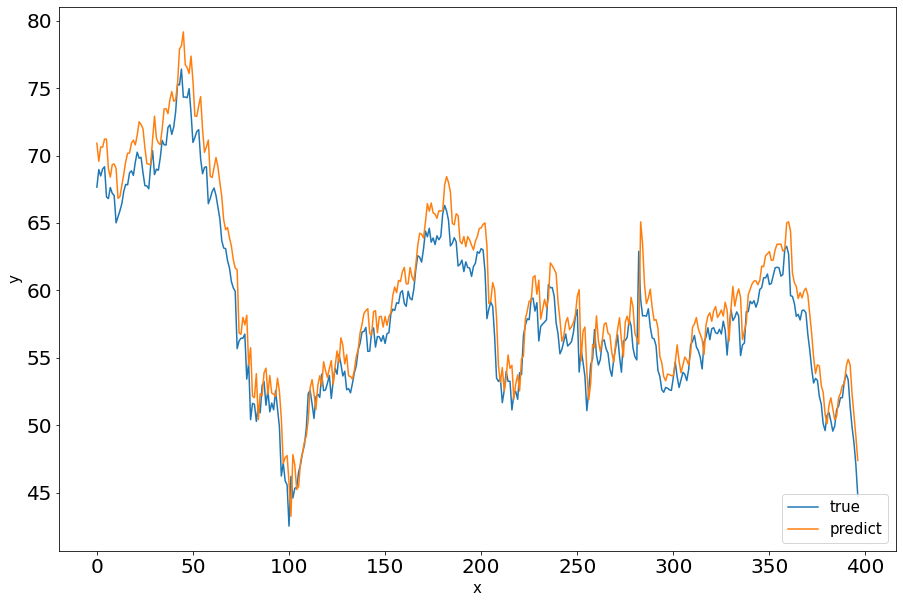

2.038858459095986

In [124]:
modelP.genGraph(l=dataP.l, h=dataP.h)
modelP.RMSE()

# w/ BatchNorm, Dropout

In [16]:
dataP1 = DataProcessor()
modelP1 = MLP(dataP1.generate_train_test(oilPrice, 5, norm=True), batchNorm=[1,2,3], dropout=[1,2,3], alpha=0)
modelP1.train()

                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 936us/step - loss: 0.0023


0.0009072372340597212

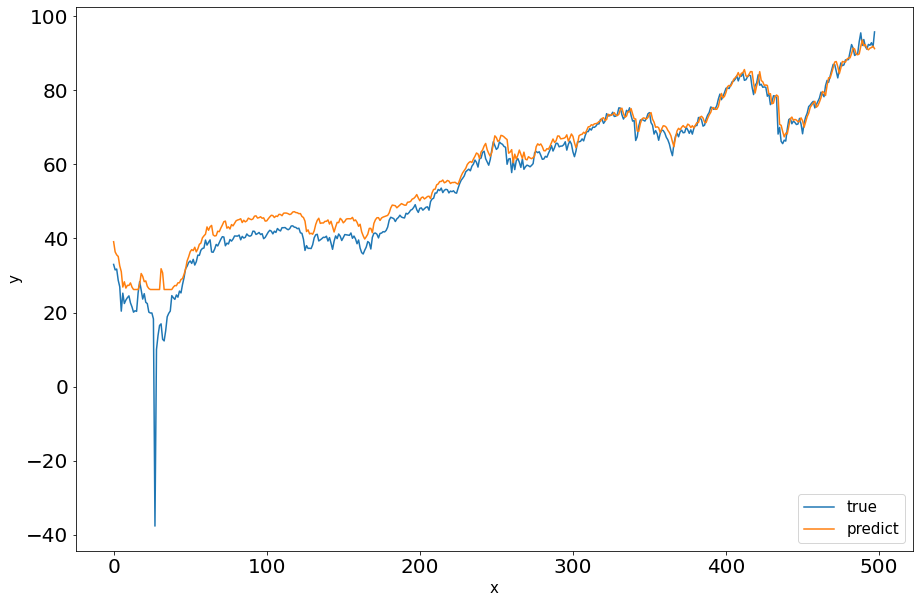

4.515891613515165

In [17]:
modelP1.genGraph(l=dataP1.l, h=dataP1.h)
modelP1.RMSE()

# w/ BatchNorm, LReLU

                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 899us/step - loss: 0.0015


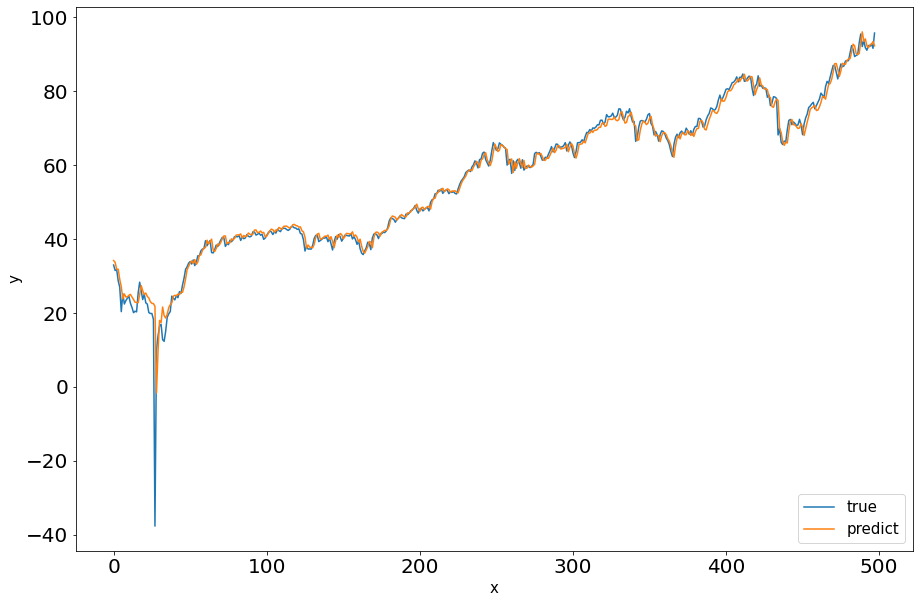

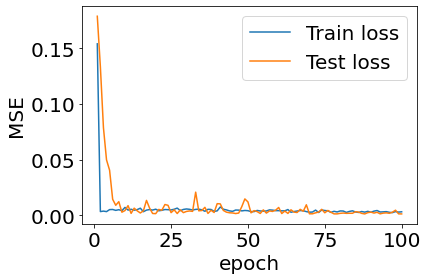

In [389]:
dataP2N = DataProcessor()
modelP2N = MLP(dataP2N.generate_train_test(oilPrice, 5, norm=True), batchNorm=[1,2,3], alpha=0.4)
modelP2N.train()

modelP2N.genGraph(l=dataP2N.l, h=dataP2N.h)
print(modelP2N.RMSE())

graphTrainTestLoss(modelP2N)

In [390]:
modelP2N.rmse

3.1717109033180173

# OPEC price w/BatchNorm

In [314]:
dataPO = DataProcessor()
modelPO = MLP(dataPO.generate_train_test(oils, 5, norm=True), batchNorm=[1,2,3], alpha=0)
modelPO.train()

                 Close   Value
Date                          
2012-02-29  107.070000  120.79
2012-03-01  108.839996  122.12
2012-03-02  106.699997  123.12
2012-03-05  106.720001  122.39
2012-03-06  104.699997  122.02
...                ...     ...
2018-07-18   68.760002   69.98
2018-07-19   69.459999   70.91
2018-07-20   70.459999   71.57
2018-07-23   67.889999   71.85
2018-07-24   68.519997   72.01

[1609 rows x 2 columns]
51/51 [==============================] - 0s 1ms/step - loss: 2.6161e-04


0.00013173669867683202

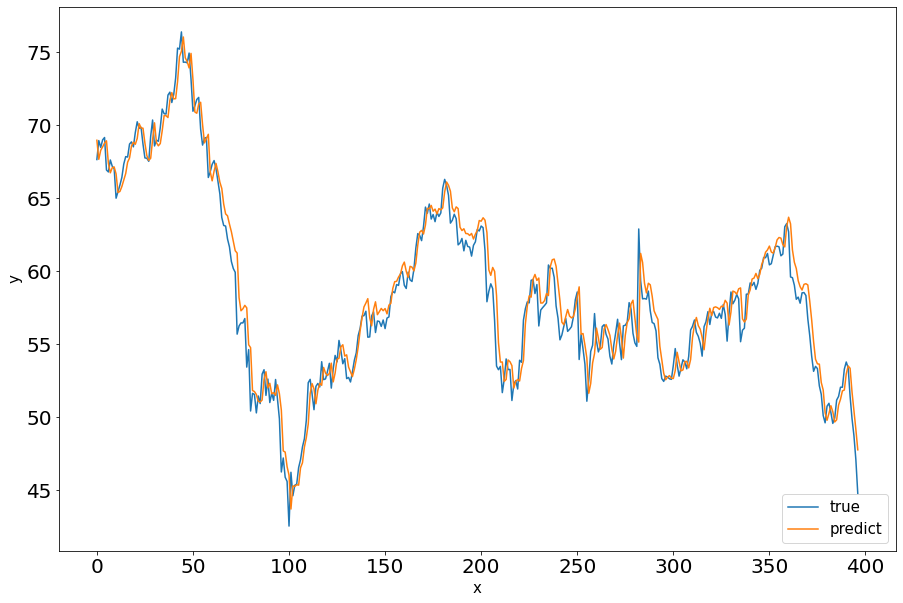

1.3995007244452535

In [315]:
modelPO.genGraph(l=dataPO.l, h=dataPO.h)
modelPO.RMSE()

# Fwd Rates on PCA w/ BatchNorm

In [19]:
dataPR = DataProcessor()
modelPR = MLP(dataPR.generate_train_test(oilRates, 5, norm=True, pca=oilRates.columns[1:]), batchNorm=[1,2,3], alpha=0)
modelPR.train()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


                 Close         0         1         2
Date                                                
2012-02-29  107.070000 -1.045931  0.338489  0.248613
2012-03-01  108.839996 -1.052903  0.304820  0.270402
2012-03-02  106.699997 -1.076629  0.348674  0.272777
2012-03-05  106.720001 -1.046523  0.333143  0.258196
2012-03-06  104.699997 -1.064239  0.384792  0.261883
...                ...       ...       ...       ...
2020-02-26   48.730000  1.016449  0.828465 -0.096336
2020-02-27   47.090000  0.930201  0.848836 -0.100121
2020-02-28   44.759998  0.672250  1.016747 -0.096161
2020-03-02   46.750000  0.546418  0.997704 -0.153279
2020-03-03   47.180000  0.277138  1.057338 -0.222621

[2013 rows x 4 columns]
63/63 [==============================] - 0s 896us/step - loss: 6.2296e-04


0.00023817377223167568

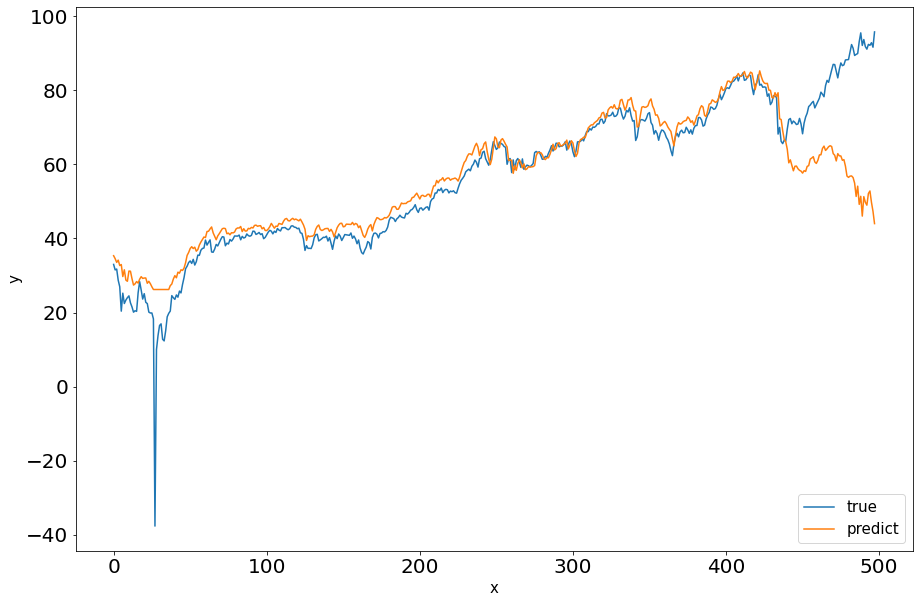

10.228787119151853


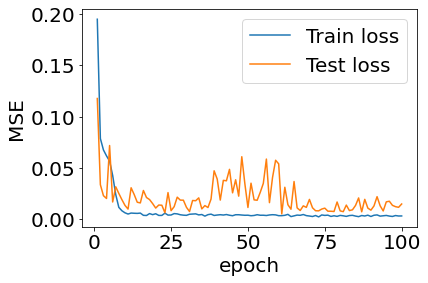

In [20]:
modelPR.genGraph(l=dataPR.l, h=dataPR.h)
print(modelPR.RMSE())

graphTrainTestLoss(modelPR)

# DXY w/ BatchNorm

In [187]:
dataPC = DataProcessor()
modelPC = MLP(dataPC.generate_train_test(oilCrncy.ffill(), 5, norm=True), batchNorm=[1,2,3], alpha=0)
modelPC.train()

                 Close   Closefac
Date                             
2012-02-29  107.070000  78.730003
2012-03-01  108.839996  78.779999
2012-03-02  106.699997  79.400002
2012-03-05  106.720001  79.320000
2012-03-06  104.699997  79.860001
...                ...        ...
2018-07-18   68.760002  95.080002
2018-07-19   69.459999  95.169998
2018-07-20   70.459999  94.459999
2018-07-23   67.889999  94.669998
2018-07-24   68.519997  94.610001

[1609 rows x 2 columns]
51/51 [==============================] - 0s 871us/step - loss: 8.4292e-04 - root_mean_squared_error: 0.0290


[0.0002041966508841142, 0.014289739541709423]

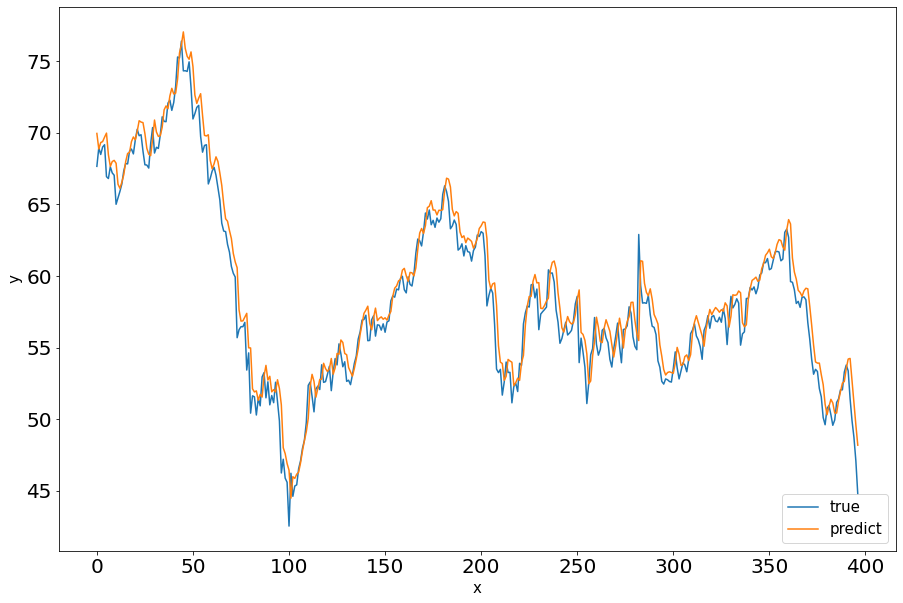

1.4799027576393247

In [188]:
modelPC.genGraph(l=dataPC.l, h=dataPC.h)
modelPC.RMSE()

# Fwd Rates on PCA + DXY w/ BatchNorm

In [373]:
dataPRC1 = DataProcessor()
modelPRC1 = MLP(dataPRC1.generate_train_test(oilRatesCrncy, 5, norm=True, pca=oilRatesCrncy.columns[2:]), batchNorm=[1,2,3], alpha=0)
modelPRC1.train()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


                 Close   Closefac         0         1         2
Date                                                           
2012-02-29  107.070000  78.730003 -0.656685  0.317128  0.237028
2012-03-01  108.839996  78.779999 -0.661008  0.284948  0.260232
2012-03-02  106.699997  79.400002 -0.689269  0.326575  0.261684
2012-03-05  106.720001  79.320000 -0.656589  0.314774  0.249326
2012-03-06  104.699997  79.860001 -0.679028  0.366178  0.255307
...                ...        ...       ...       ...       ...
2018-07-18   68.760002  95.080002  2.265399 -0.038445  0.256005
2018-07-19   69.459999  95.169998  2.255852 -0.021582  0.244477
2018-07-20   70.459999  94.459999  2.246711 -0.043765  0.253177
2018-07-23   67.889999  94.669998  2.267881 -0.075026  0.271275
2018-07-24   68.519997  94.610001  2.287274 -0.077318  0.278722

[1609 rows x 5 columns]
51/51 [==============================] - 0s 1ms/step - loss: 8.9955e-04


KeyboardInterrupt: 

In [ ]:
modelPRC1.genGraph(l=dataPRC1.l, h=dataPRC1.h)
modelPRC1.RMSE()

# Volume + DXY w/ BatchNorm

In [259]:
dataPVC1 = DataProcessor()
modelPVC1 = MLP(dataPVC1.generate_train_test(oilVolCrncy.ffill(), 5, norm=True), batchNorm=[1,2,3], alpha=0)
modelPVC1.train()

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 927us/step - loss: 3.7697e-04 - root_mean_squared_error: 0.0194


[0.0002020781539613381, 0.014215420000255108]

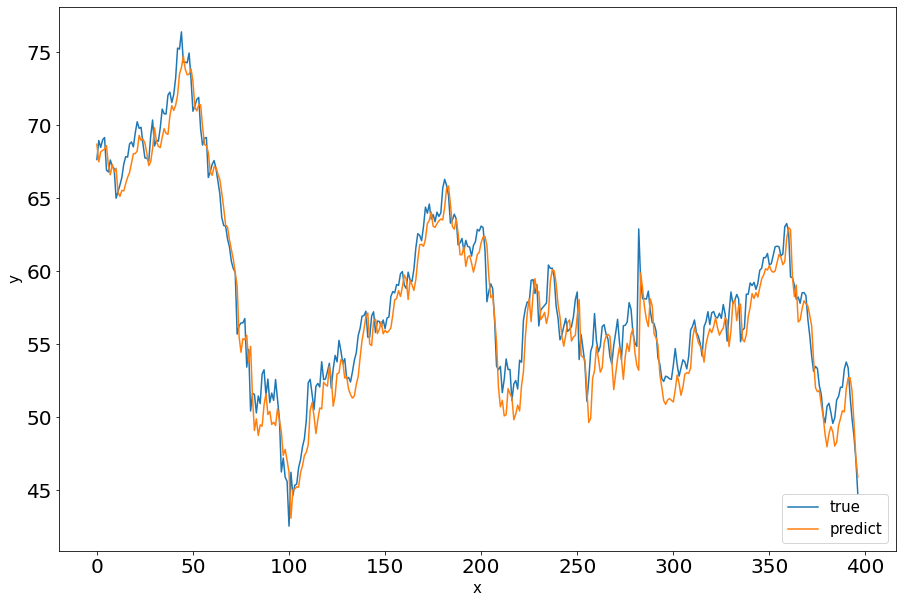

1.6397321009627275

In [260]:
modelPVC1.genGraph(l=dataPVC1.l, h=dataPVC1.h)
modelPVC1.RMSE()

# ---

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 1ms/step - loss: 3.3129e-04 - root_mean_squared_error: 0.0182


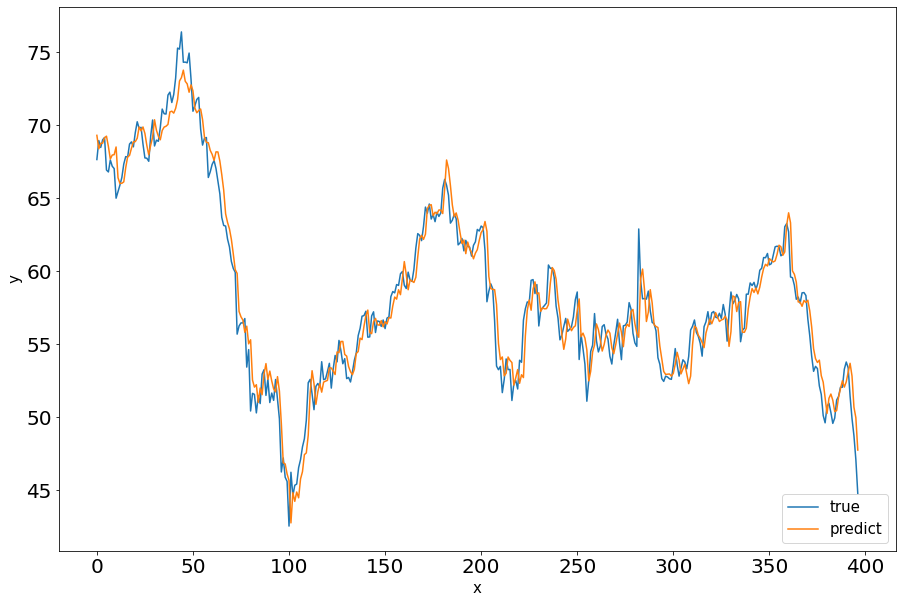

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 960us/step - loss: 6.1220e-04 - root_mean_squared_error: 0.0247


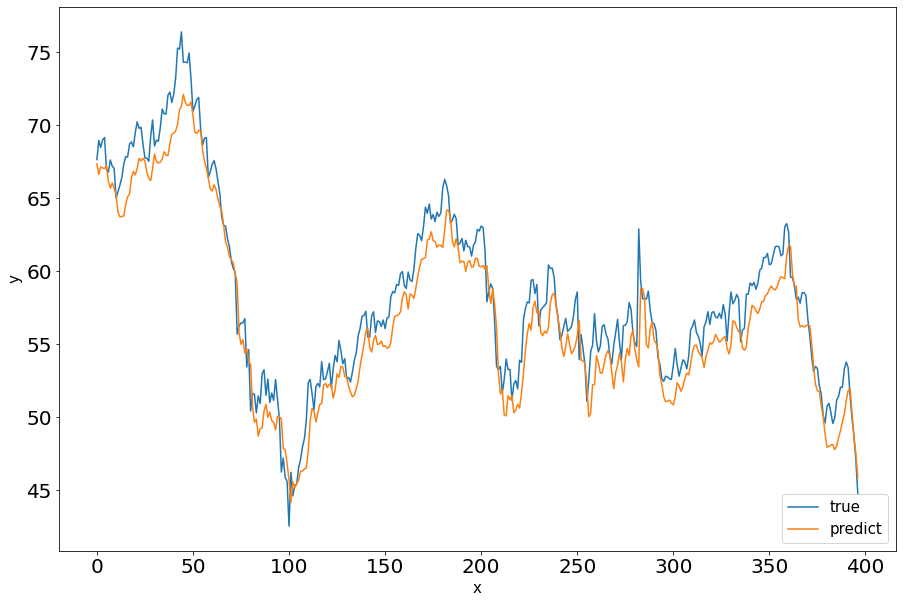

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 935us/step - loss: 0.0011 - root_mean_squared_error: 0.0328


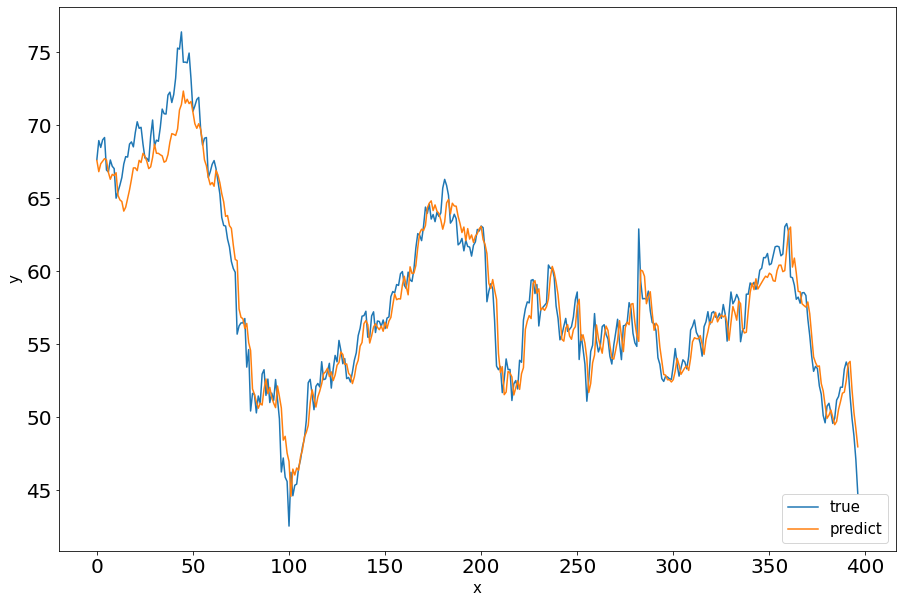

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 940us/step - loss: 0.0024 - root_mean_squared_error: 0.0493


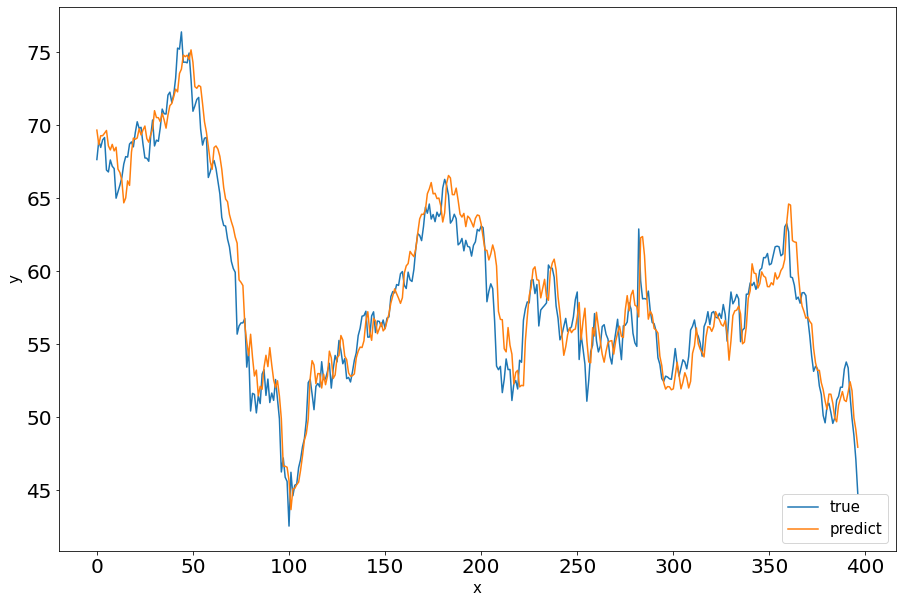

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 877us/step - loss: 9.9875e-04 - root_mean_squared_error: 0.0316


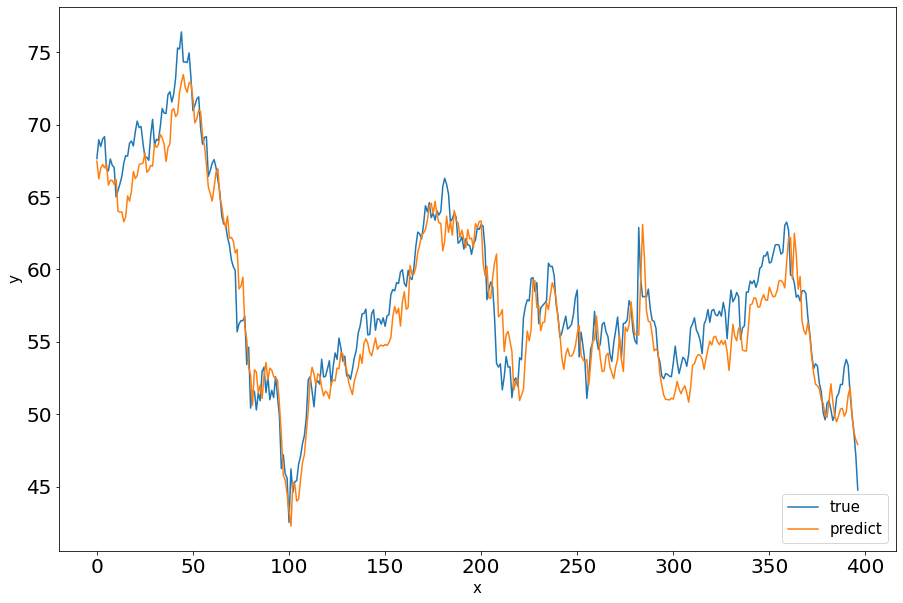

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 874us/step - loss: 0.0021 - root_mean_squared_error: 0.0459


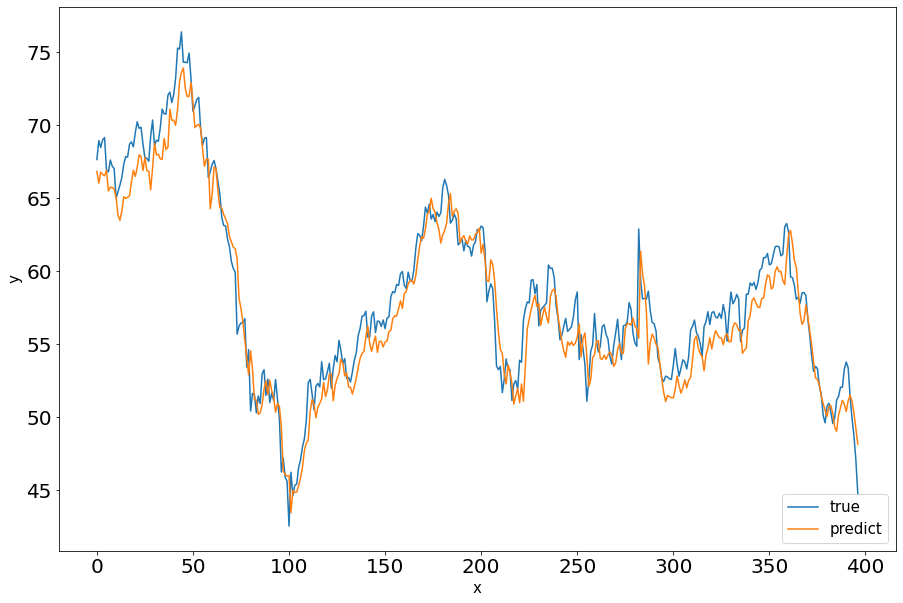

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 944us/step - loss: 3.9722e-04 - root_mean_squared_error: 0.0199


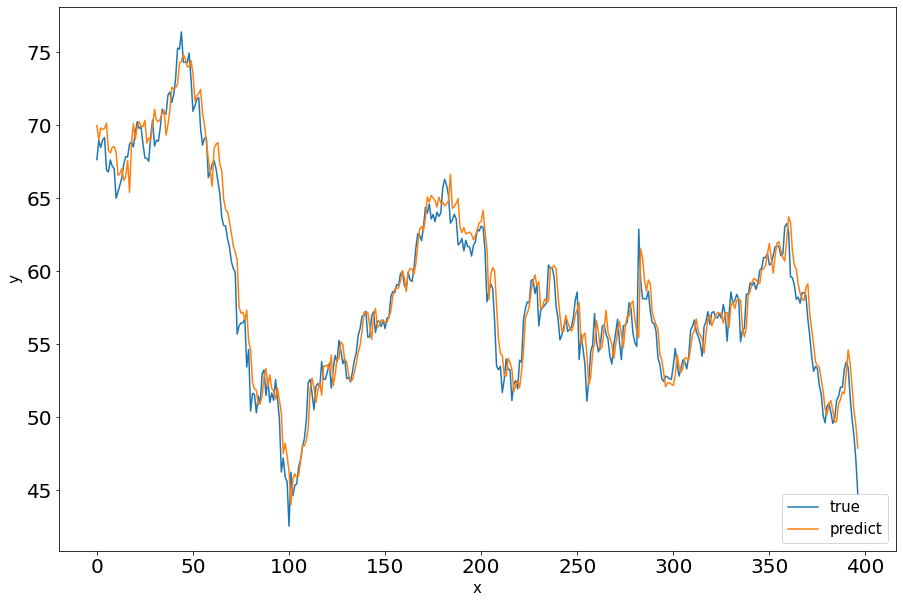

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 965us/step - loss: 0.0023 - root_mean_squared_error: 0.0485


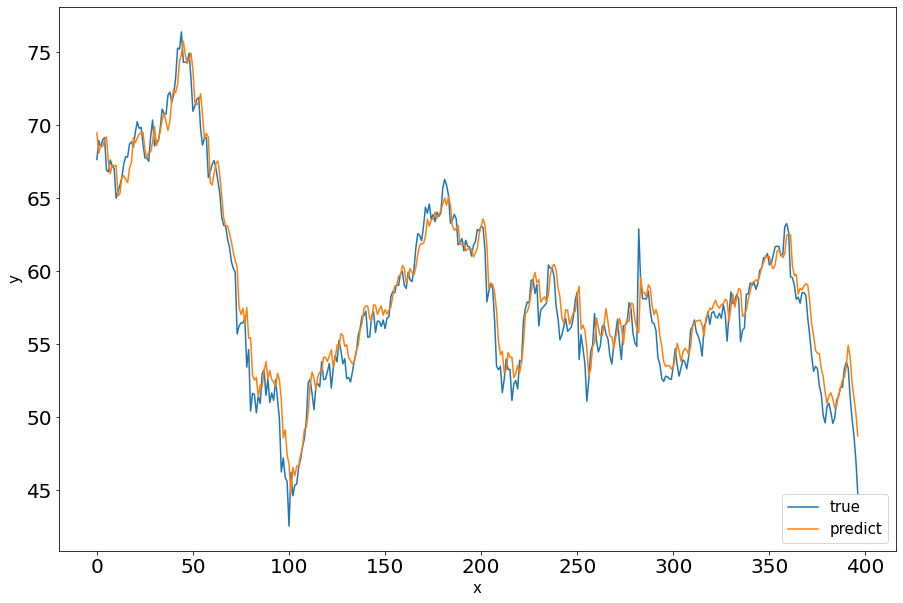

                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]
51/51 [==============================] - 0s 1ms/step - loss: 5.7359e-04 - root_mean_squared_error: 0.0239


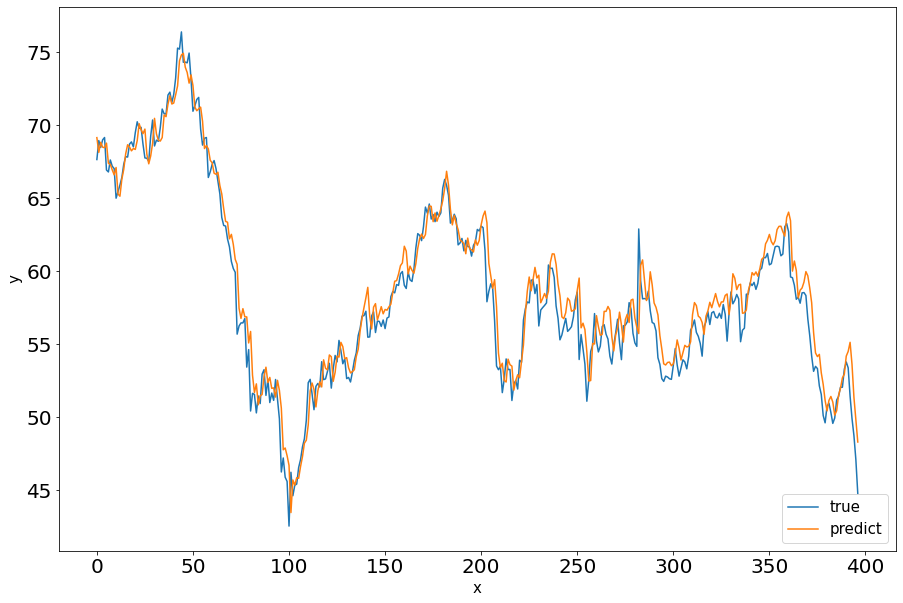

In [275]:
lreluAlphaModels = []
dataPVC2 = DataProcessor()
for i in np.arange(0,0.55,0.05):
    modelPVC2 = MLP(dataPVC2.generate_train_test(oilVolCrncy.ffill(), 5, norm=True), batchNorm=[1,2,3], alpha=i)
    modelPVC2.train()
    modelPVC2.genGraph(l=dataPVC2.l, h=dataPVC2.h, title=f"Alpha: {i}")
    reluAlpha.append([i, modelPVC2])

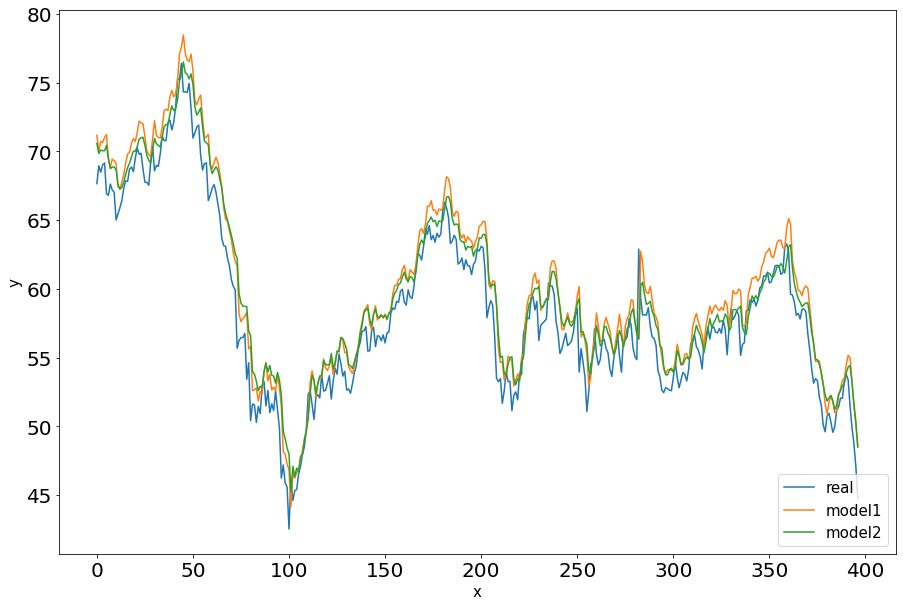

In [151]:
compareModelGraph(modelP, modelPR)

# (L)ReLU w/ BatchNorm

                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 931us/step - loss: 0.0022


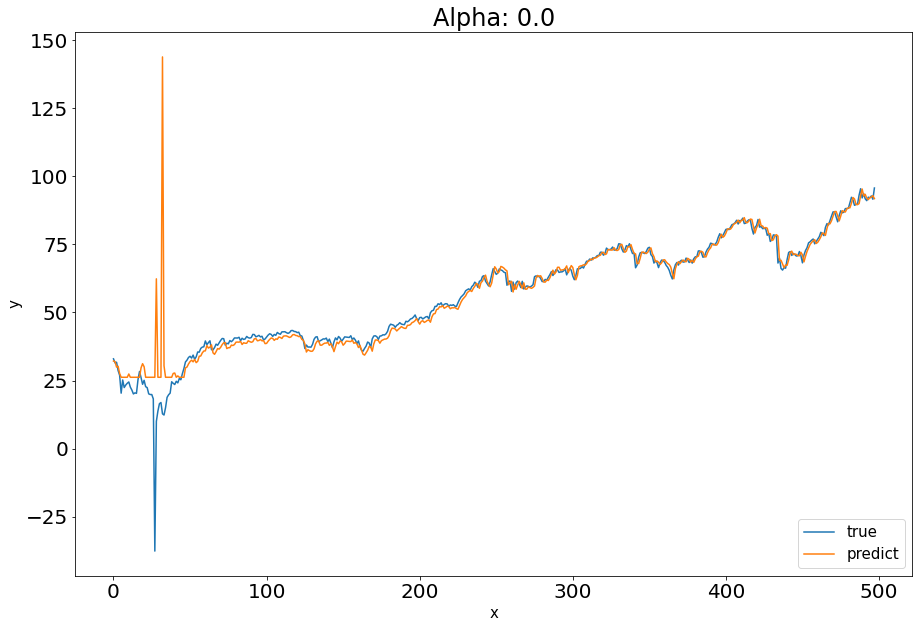

7.340808261844477
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 827us/step - loss: 0.0065


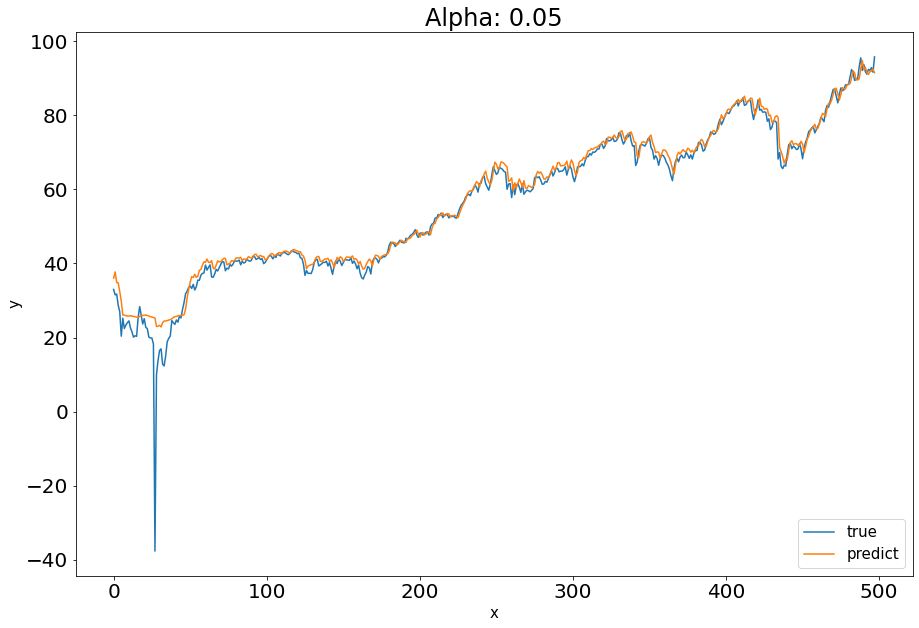

3.6370218576118267
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 731us/step - loss: 0.0018


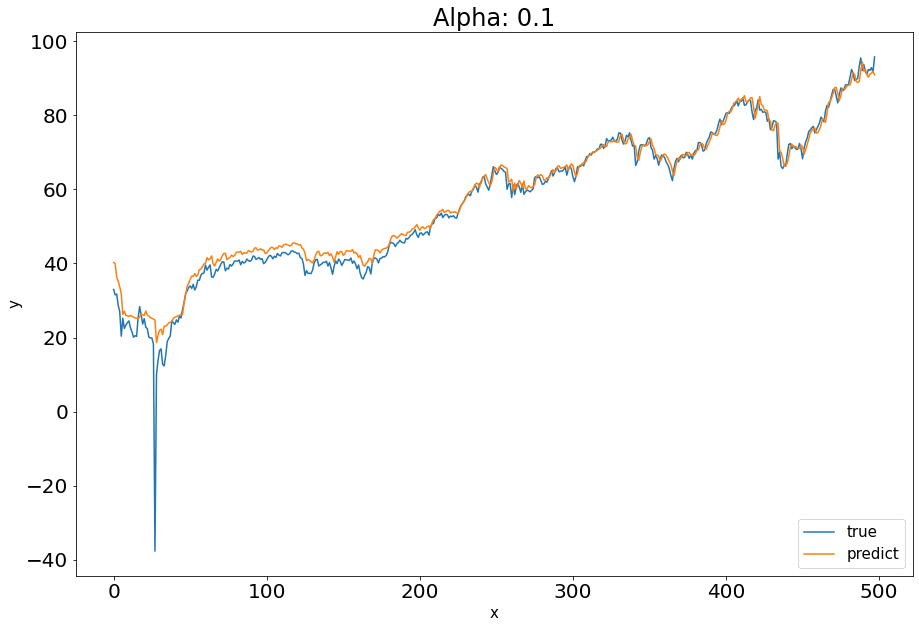

3.7141500560300047
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 772us/step - loss: 4.8376e-04


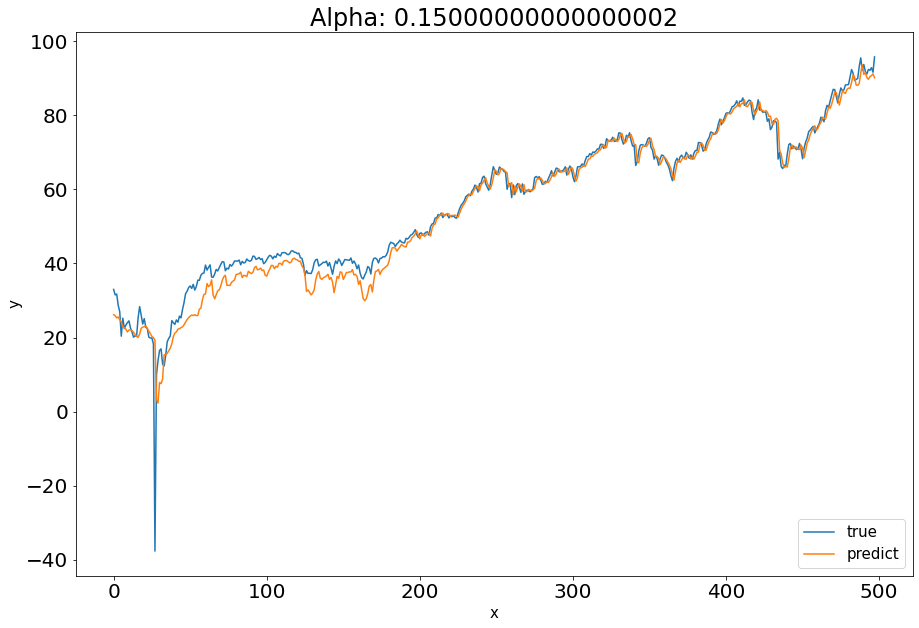

3.930194753392997
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 724us/step - loss: 0.0032


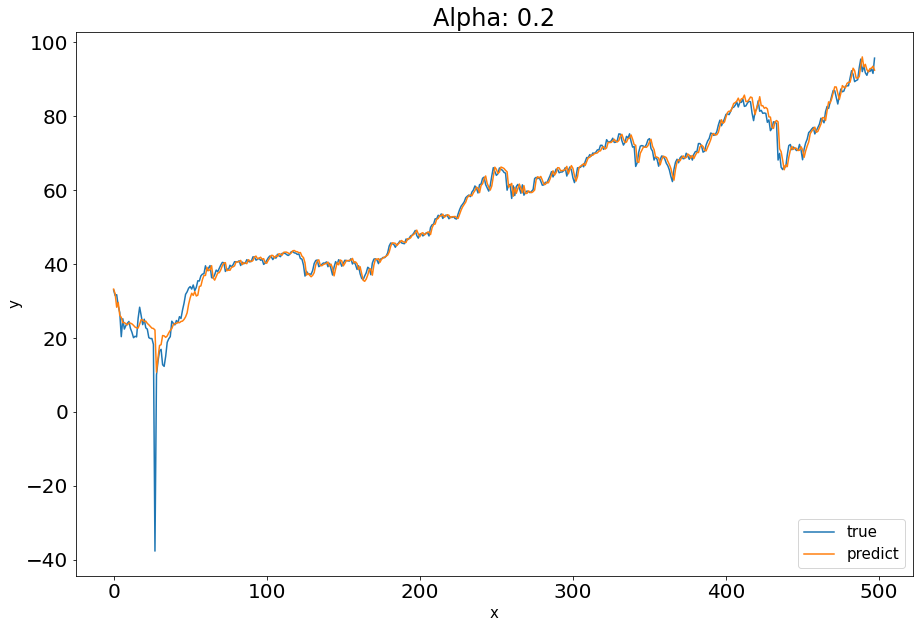

3.1759866042757525
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 711us/step - loss: 0.0012


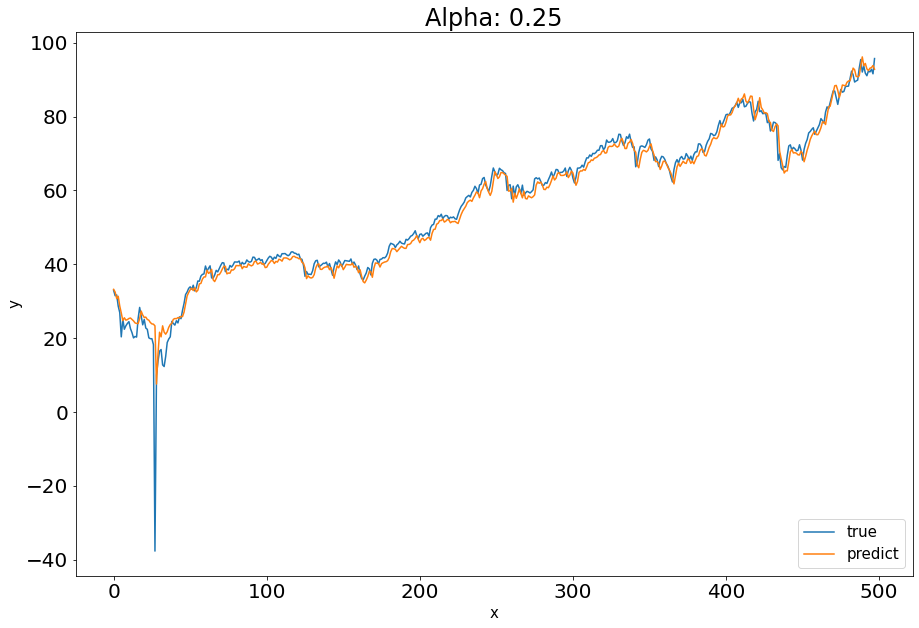

3.412395800973669
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 778us/step - loss: 0.0019


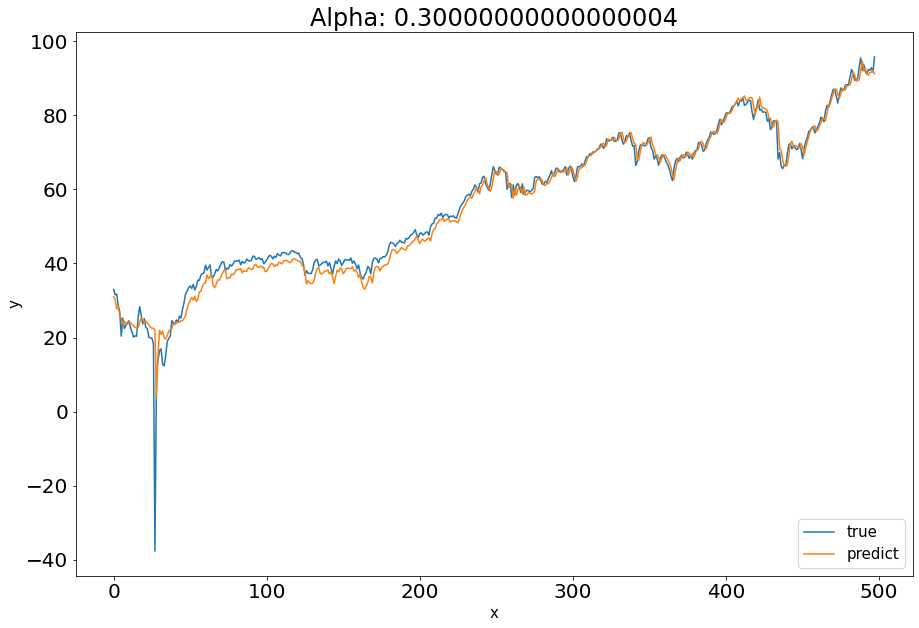

3.4681451146316062
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 784us/step - loss: 0.0017


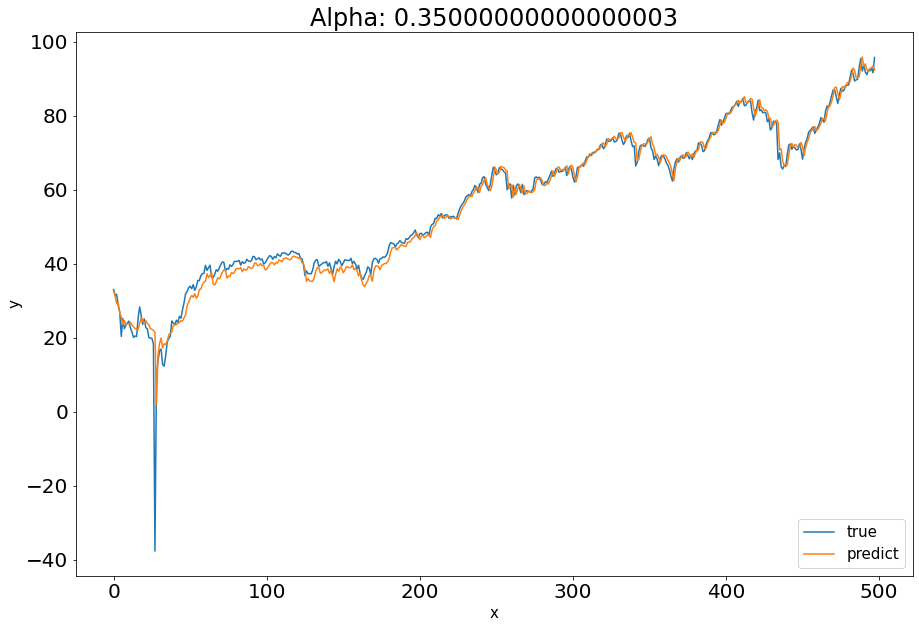

3.2694355063942164
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 751us/step - loss: 0.0018


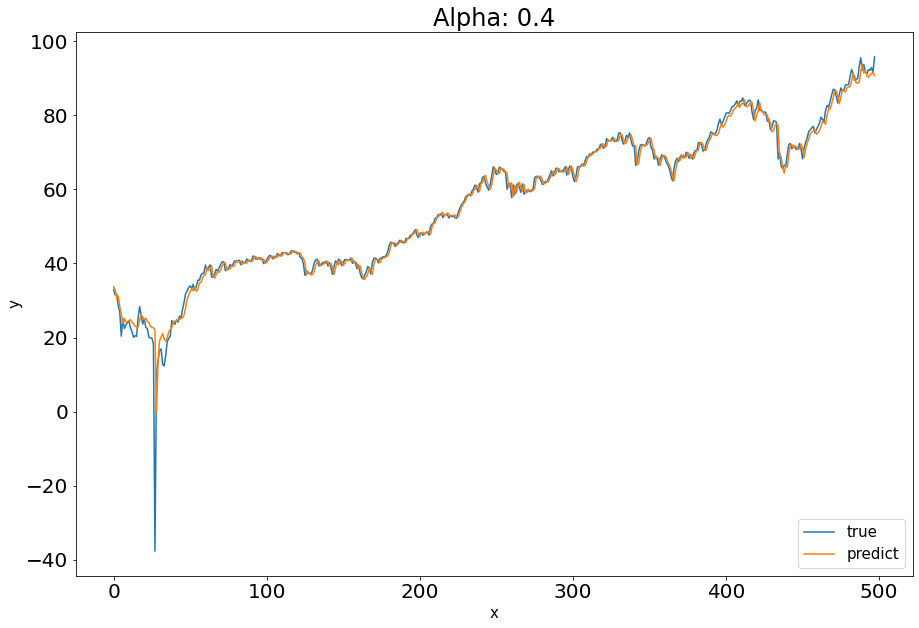

3.1632065490621026
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 773us/step - loss: 5.0110e-04


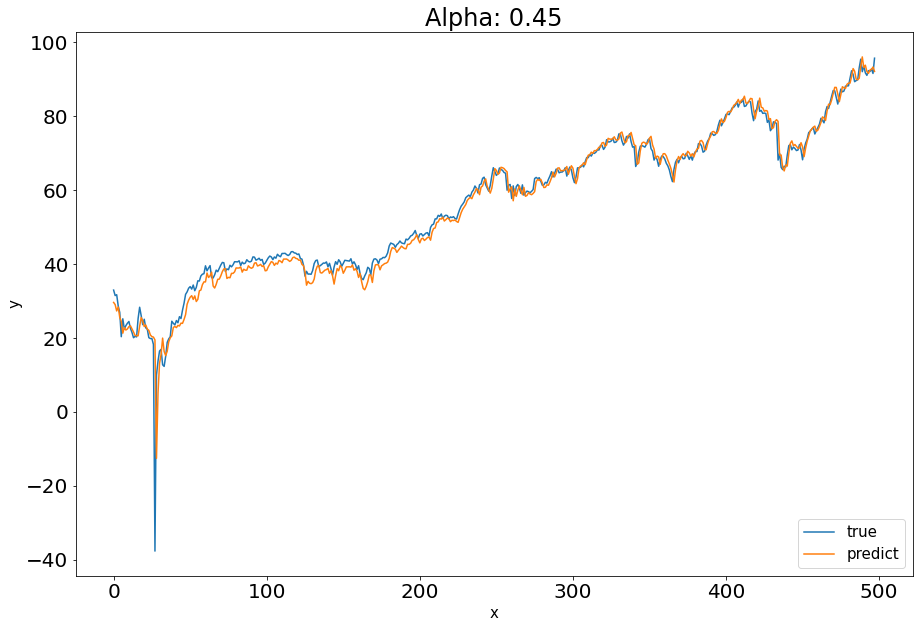

3.406444356382576
                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000
2020-03-03   47.180000

[2013 rows x 1 columns]
63/63 [==============================] - 0s 854us/step - loss: 0.0011


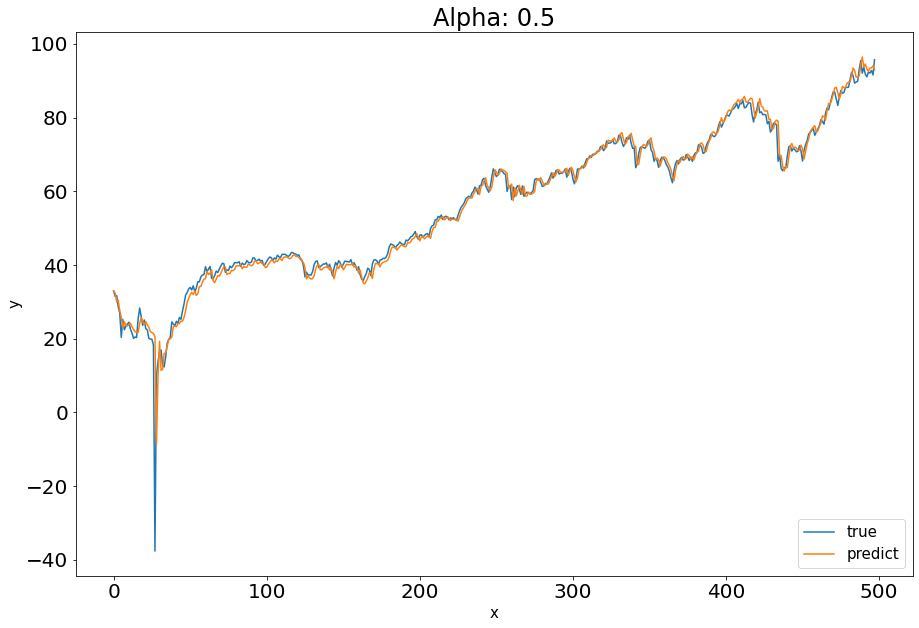

3.2067395360787736


In [23]:
lreluPModels = []
dataPlrelu = DataProcessor()
for i in np.arange(0,0.55,0.05):
    modelPlrelu = MLP(dataPlrelu.generate_train_test(oilPrice, 5, norm=True), batchNorm=[1,2,3], alpha=i)
    modelPlrelu.train()
    modelPlrelu.genGraph(l=dataPlrelu.l, h=dataPlrelu.h, title=f"Alpha: {i}")
    print(modelPlrelu.RMSE())
    lreluPModels.append([i, modelPlrelu])

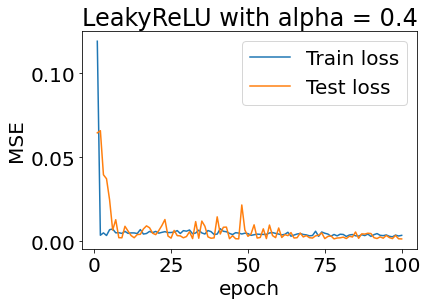

In [29]:
graphTrainTestLoss(lreluPModels[-3][1], title="LeakyReLU with alpha = 0.4")